# Comparison of xDbit data with published bulk RNA-seq datasets

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
## Import the custom library
import os
import sys

# add xDbit toolbox path to path variable
module_path = os.path.abspath("../../")
if module_path not in sys.path:
    sys.path.append(module_path)

import dbitx_funcs as db

In [3]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path
import seaborn as sns
import gc
import anndata

In [4]:
plt.rcParams['figure.dpi'] = 100
plt.style.use('default')

## Data source
- ENCODE database: https://www.encodeproject.org/

- URLs of the datasets that have been used can be found here: `xDbit_toolbox/publication/source_data/encode_data_urls.txt`

### Load bulk data

In [5]:
#tsv_files = glob(os.path.join(HOME, "data", "datasets/encode_rnaseq/*"))
tsv_files = glob("D:/data/SpatialMouse/encode_rnaseq/*.tsv")

organs = [os.path.basename(elem).split("_")[0] for elem in tsv_files]

In [6]:
bulks = {os.path.basename(elem).split("_")[0]: pd.read_csv(elem, sep="\t", skiprows=1) for elem in tsv_files}

In [7]:
# sort out genes with no reads
for organ, bulk in bulks.items():
    print("Sum of TPM in {} sample: {}".format(bulk['TPM'].sum(), organ))
    bulks[organ] = bulk.query('TPM > 0')

Sum of TPM in 1000002.32 sample: Brain
Sum of TPM in 999998.81 sample: Heart
Sum of TPM in 999998.26 sample: Kidney
Sum of TPM in 1000000.77 sample: Liver
Sum of TPM in 2000000.8699999999 sample: Spleen


## Notes

1. The dataset was normalized to 1 million counts
2. In most of the bulk datasets the Feature ID `ENSMUSG00000106106.2` is very highly expressed. This ID corresponds to the gene `CT010467.1` which we also found as extremely high expressed in our dataset. This bulk dataset is also a "polyA plus RNAseq" dataset, so enriched for polyA. So this seems to be an inherent problem in methods using poly(A) capture seqs.

In [8]:
# sort out reads without gene symbol
for organ, bulk in bulks.items():
    bulks[organ] = bulk[bulk["Gene symbol"].notna()]

### Generate adatas for bulk data

In [9]:
adbulks = {}
for organ, bulk in bulks.items():
    df = pd.DataFrame()
    for exp in bulk["Experiment"].unique():
        # select experiment - Spleen e.g. has multiple experiments
        b = bulk.query('Experiment == "{}"'.format(exp))
        b.index = b["Feature ID"]

        # add to dataframe per experiment
        df[exp] = b['TPM']
        #df.index = b['Gene symbol']
    df = df.dropna()
    
    df['gene'] = b['Gene symbol']
    feat_ids = df.index
    df.index = df['gene']
    df = df.drop('gene', axis=1)
    
    # create anndata
    a = anndata.AnnData(df.T)
    a.obs['type'] = 'bulk'
    a.obs['id'] = [elem.strip("/").split("/")[-1] for elem in a.obs.index]
    a.obs_names = a.obs['id']
    a.var['feature_id'] = feat_ids
    
    print("Make .var_names unique...")
    a.var_names_make_unique()
    
    adbulks[organ] = a

C:\Users\Johannes\anaconda3\envs\spatial\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\Johannes\anaconda3\envs\spatial\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\Johannes\anaconda3\envs\spatial\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\Johannes\anaconda3\envs\spatial\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\Johannes\anaconda3\envs\spatial\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Varia

Make .var_names unique...
Make .var_names unique...
Make .var_names unique...
Make .var_names unique...
Make .var_names unique...


### Load spatial data

In [10]:
#spatial_dir = os.path.join(HOME, "data/experiments/SpatialMouse/analysis/perOrgan")
spatial_dir = "out"

spatial_files = glob(os.path.join(spatial_dir, "*_filtered_unnorm*.h5ad"))

In [11]:
spatials = {os.path.basename(f).split("_")[0]: sc.read(f) for f in spatial_files}

In [12]:
spatials

{'Brain': AnnData object with n_obs × n_vars = 1880 × 7735
     obs: 'array_row', 'array_col', 'um_row', 'um_col', 'id', 'pixel_row', 'pixel_col', 'dapi_mean', 'dapi_mean_norm', 'experiment_id', 'organism', 'age', 'organ', 'age_months', 'mouse_id', 'exp_date', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'CT010467.1_pct'
     var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
     uns: 'matchedVis', 'registered', 'spatial'
     obsm: 'spatial',
 'Heart': AnnData object with n_obs × n_vars = 4023 × 6105
     obs: 'array_row', 'array_col', 'um_row', 'um_col', 'id', 'pixel_row', 'pixel_col', 'dapi_mean', 'dapi_mean_norm', 'experiment_id', 'organism', 'age', 'organ', 'age_months', 'mouse_id', 'exp_date', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'CT010467.1_pct'
     var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
     uns: 'matchedVis', 'registered', 'spati

#### Generate pseudobulk

In [13]:
# generate pseudobulk per id per organ
pseudos = {}
for organ, spatial in spatials.items():
    X = np.array([spatial.X[spatial.obs['id'] == i, :].sum(axis=0) for i in spatial.obs['id'].unique()])
    df = pd.DataFrame(X, index=spatial.obs['id'].unique(), columns=spatial.var_names)
    a = anndata.AnnData(df)
    a.obs['type'] = 'spatial'
    a.obs['id'] = a.obs.index
    pseudos[organ] = a

C:\Users\Johannes\anaconda3\envs\spatial\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\Johannes\anaconda3\envs\spatial\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\Johannes\anaconda3\envs\spatial\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\Johannes\anaconda3\envs\spatial\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\Johannes\anaconda3\envs\spatial\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Tr

In [14]:
pseudos

{'Brain': AnnData object with n_obs × n_vars = 2 × 7735
     obs: 'type', 'id',
 'Heart': AnnData object with n_obs × n_vars = 4 × 6105
     obs: 'type', 'id',
 'Kidney': AnnData object with n_obs × n_vars = 4 × 15027
     obs: 'type', 'id',
 'Liver': AnnData object with n_obs × n_vars = 2 × 9114
     obs: 'type', 'id',
 'Spleen': AnnData object with n_obs × n_vars = 4 × 17685
     obs: 'type', 'id'}

#### Normalize pseudobulk

In [15]:
for organ, pseudo in pseudos.items():
    pseudo.layers['counts'] = pseudo.X.copy()
    sc.pp.normalize_total(pseudo, target_sum=1000000)

### Combine datasets per organ

### Select the right organs

In [16]:
common_organs = [k for k in adbulks.keys() if k in pseudos.keys()]

In [17]:
common_organs

['Brain', 'Heart', 'Kidney', 'Liver', 'Spleen']

In [18]:
combs = {}
for organ in common_organs:
    combs[organ] = anndata.concat([adbulks[organ], pseudos[organ]], index_unique=None)
    combs[organ].obs['id'] = pd.Categorical(combs[organ].obs_names)
    combs[organ].obs['type'] = pd.Categorical(combs[organ].obs['type'])

## Log normalization

In [19]:
for organ, comb in combs.items():
    comb.layers['norm_counts'] = comb.X.copy()
    sc.pp.log1p(comb)

## Pearson correlation

In [20]:
from scipy.stats import pearsonr

def pearson_facet_plot(long_df, groupby, 
                       savepath=None, save_only=False, dpi_save=300):
    indices = long_df[groupby].unique()

    n = len(indices)

    fig, axs = plt.subplots(n, n, figsize=(8*n, 6*n))

    for r, rid in enumerate(indices):
        for c, cid in enumerate(indices):
            x = long_df.query('{} == "{}"'.format(groupby, cid))['value'].values
            y = long_df.query('{} == "{}"'.format(groupby, rid))['value'].values

            axs[r, c].scatter(x, y)
            axs[r, c].set_title("r = {}".format(round(pearsonr(x, y)[0], 2)), fontsize=20)
            if r == n-1:
                axs[r, c].set_xlabel(cid, fontsize=20)

            if c == 0:
                axs[r, c].set_ylabel(rid, fontsize=20)
                
    db.pl.save_and_show_figure(savepath=savepath, save_only=save_only, dpi_save=dpi_save)

In [21]:
comb_df = {}

for organ, comb in combs.items():
    df = comb.to_df()
    df = pd.concat([comb.obs, df], axis=1)
    comb_df[organ] = df.melt(id_vars=comb.obs.columns)

Saving figure to file figures/scatter_pearson_Brain.png
Saved.


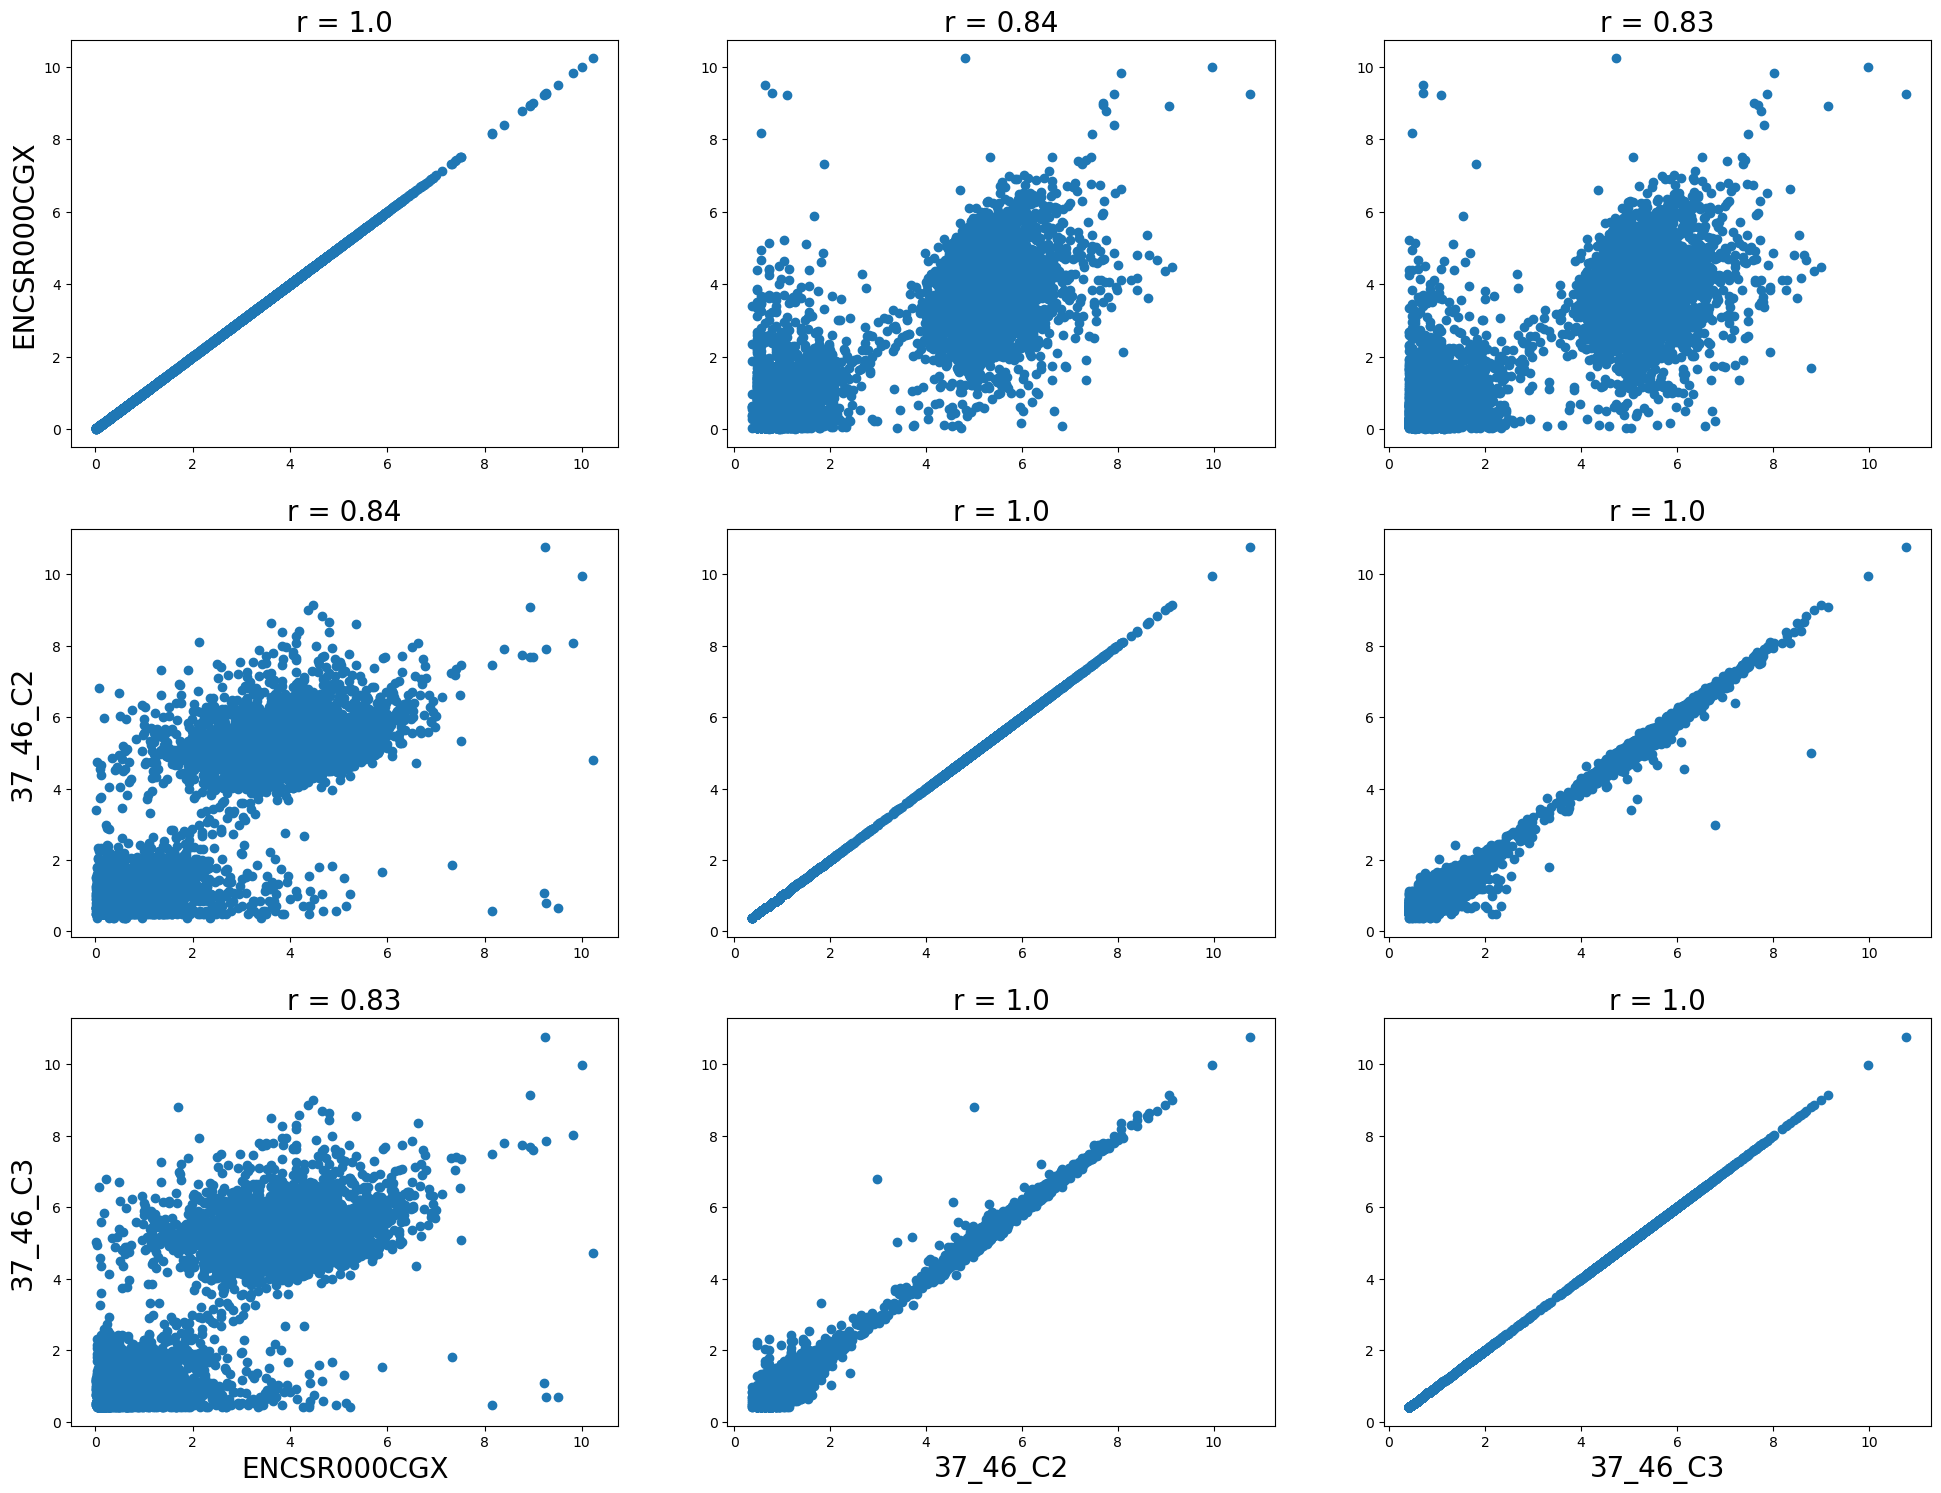

Saving figure to file figures/scatter_pearson_Heart.png
Saved.


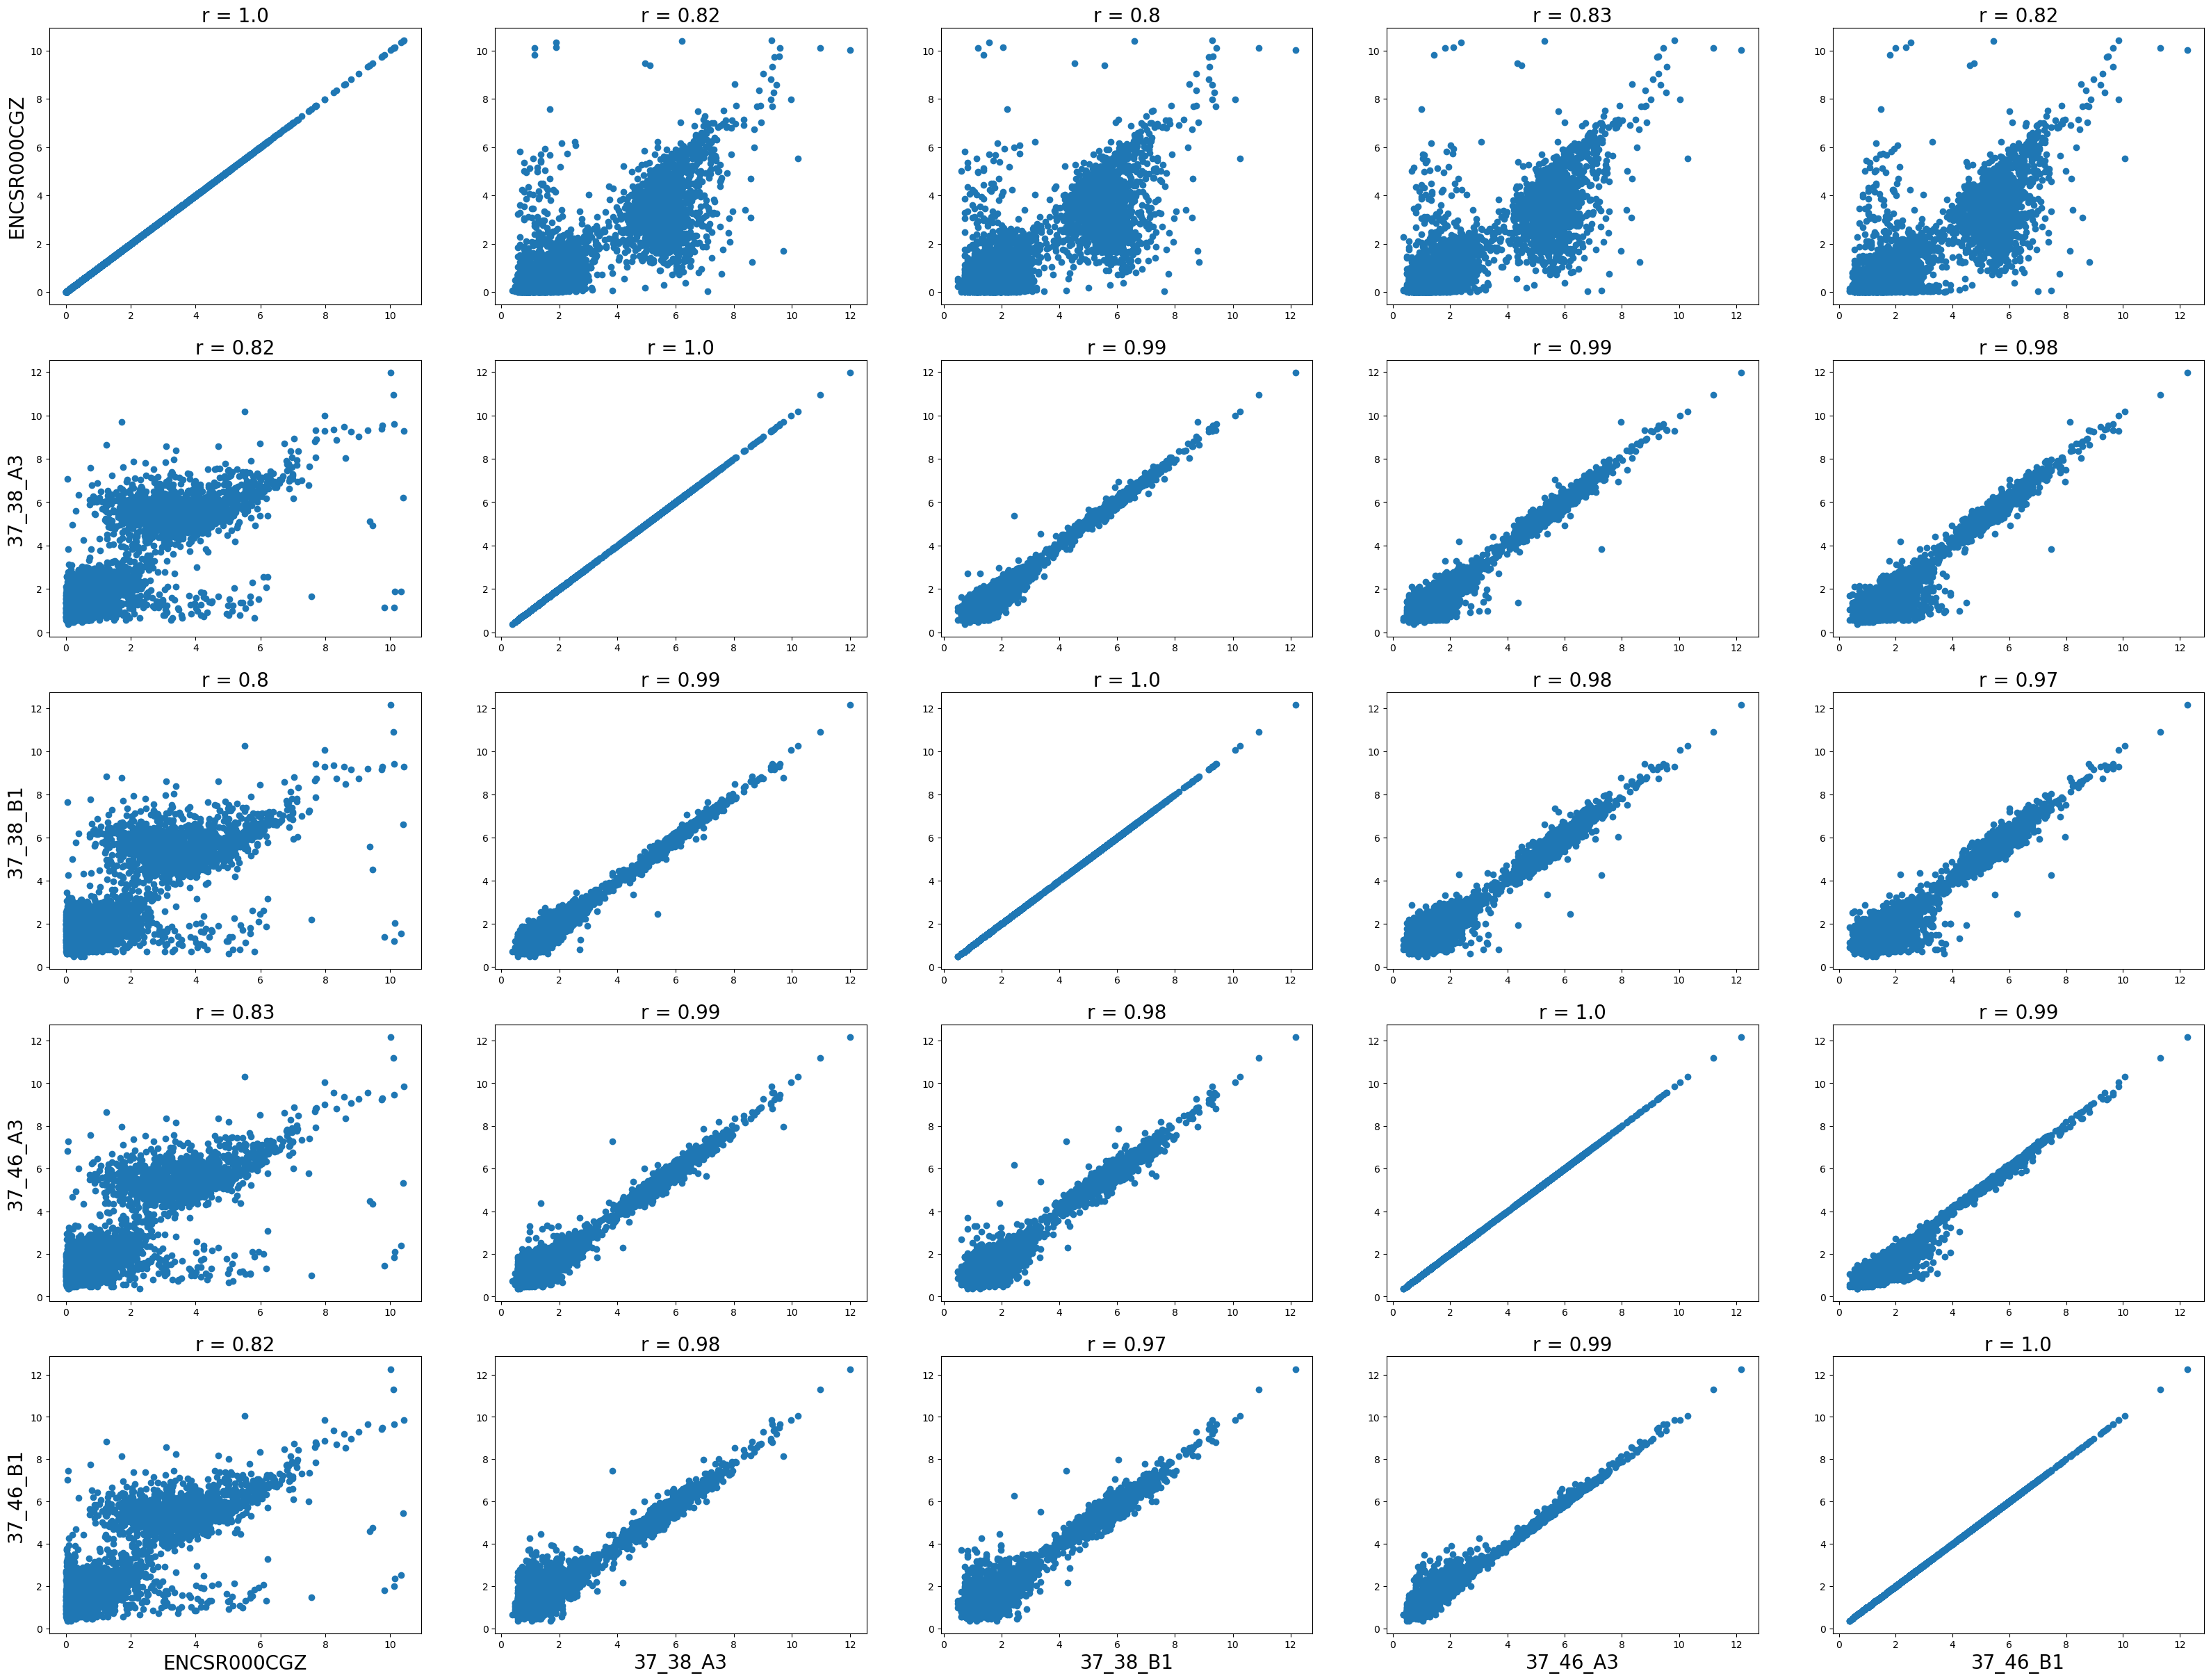

Saving figure to file figures/scatter_pearson_Kidney.png
Saved.


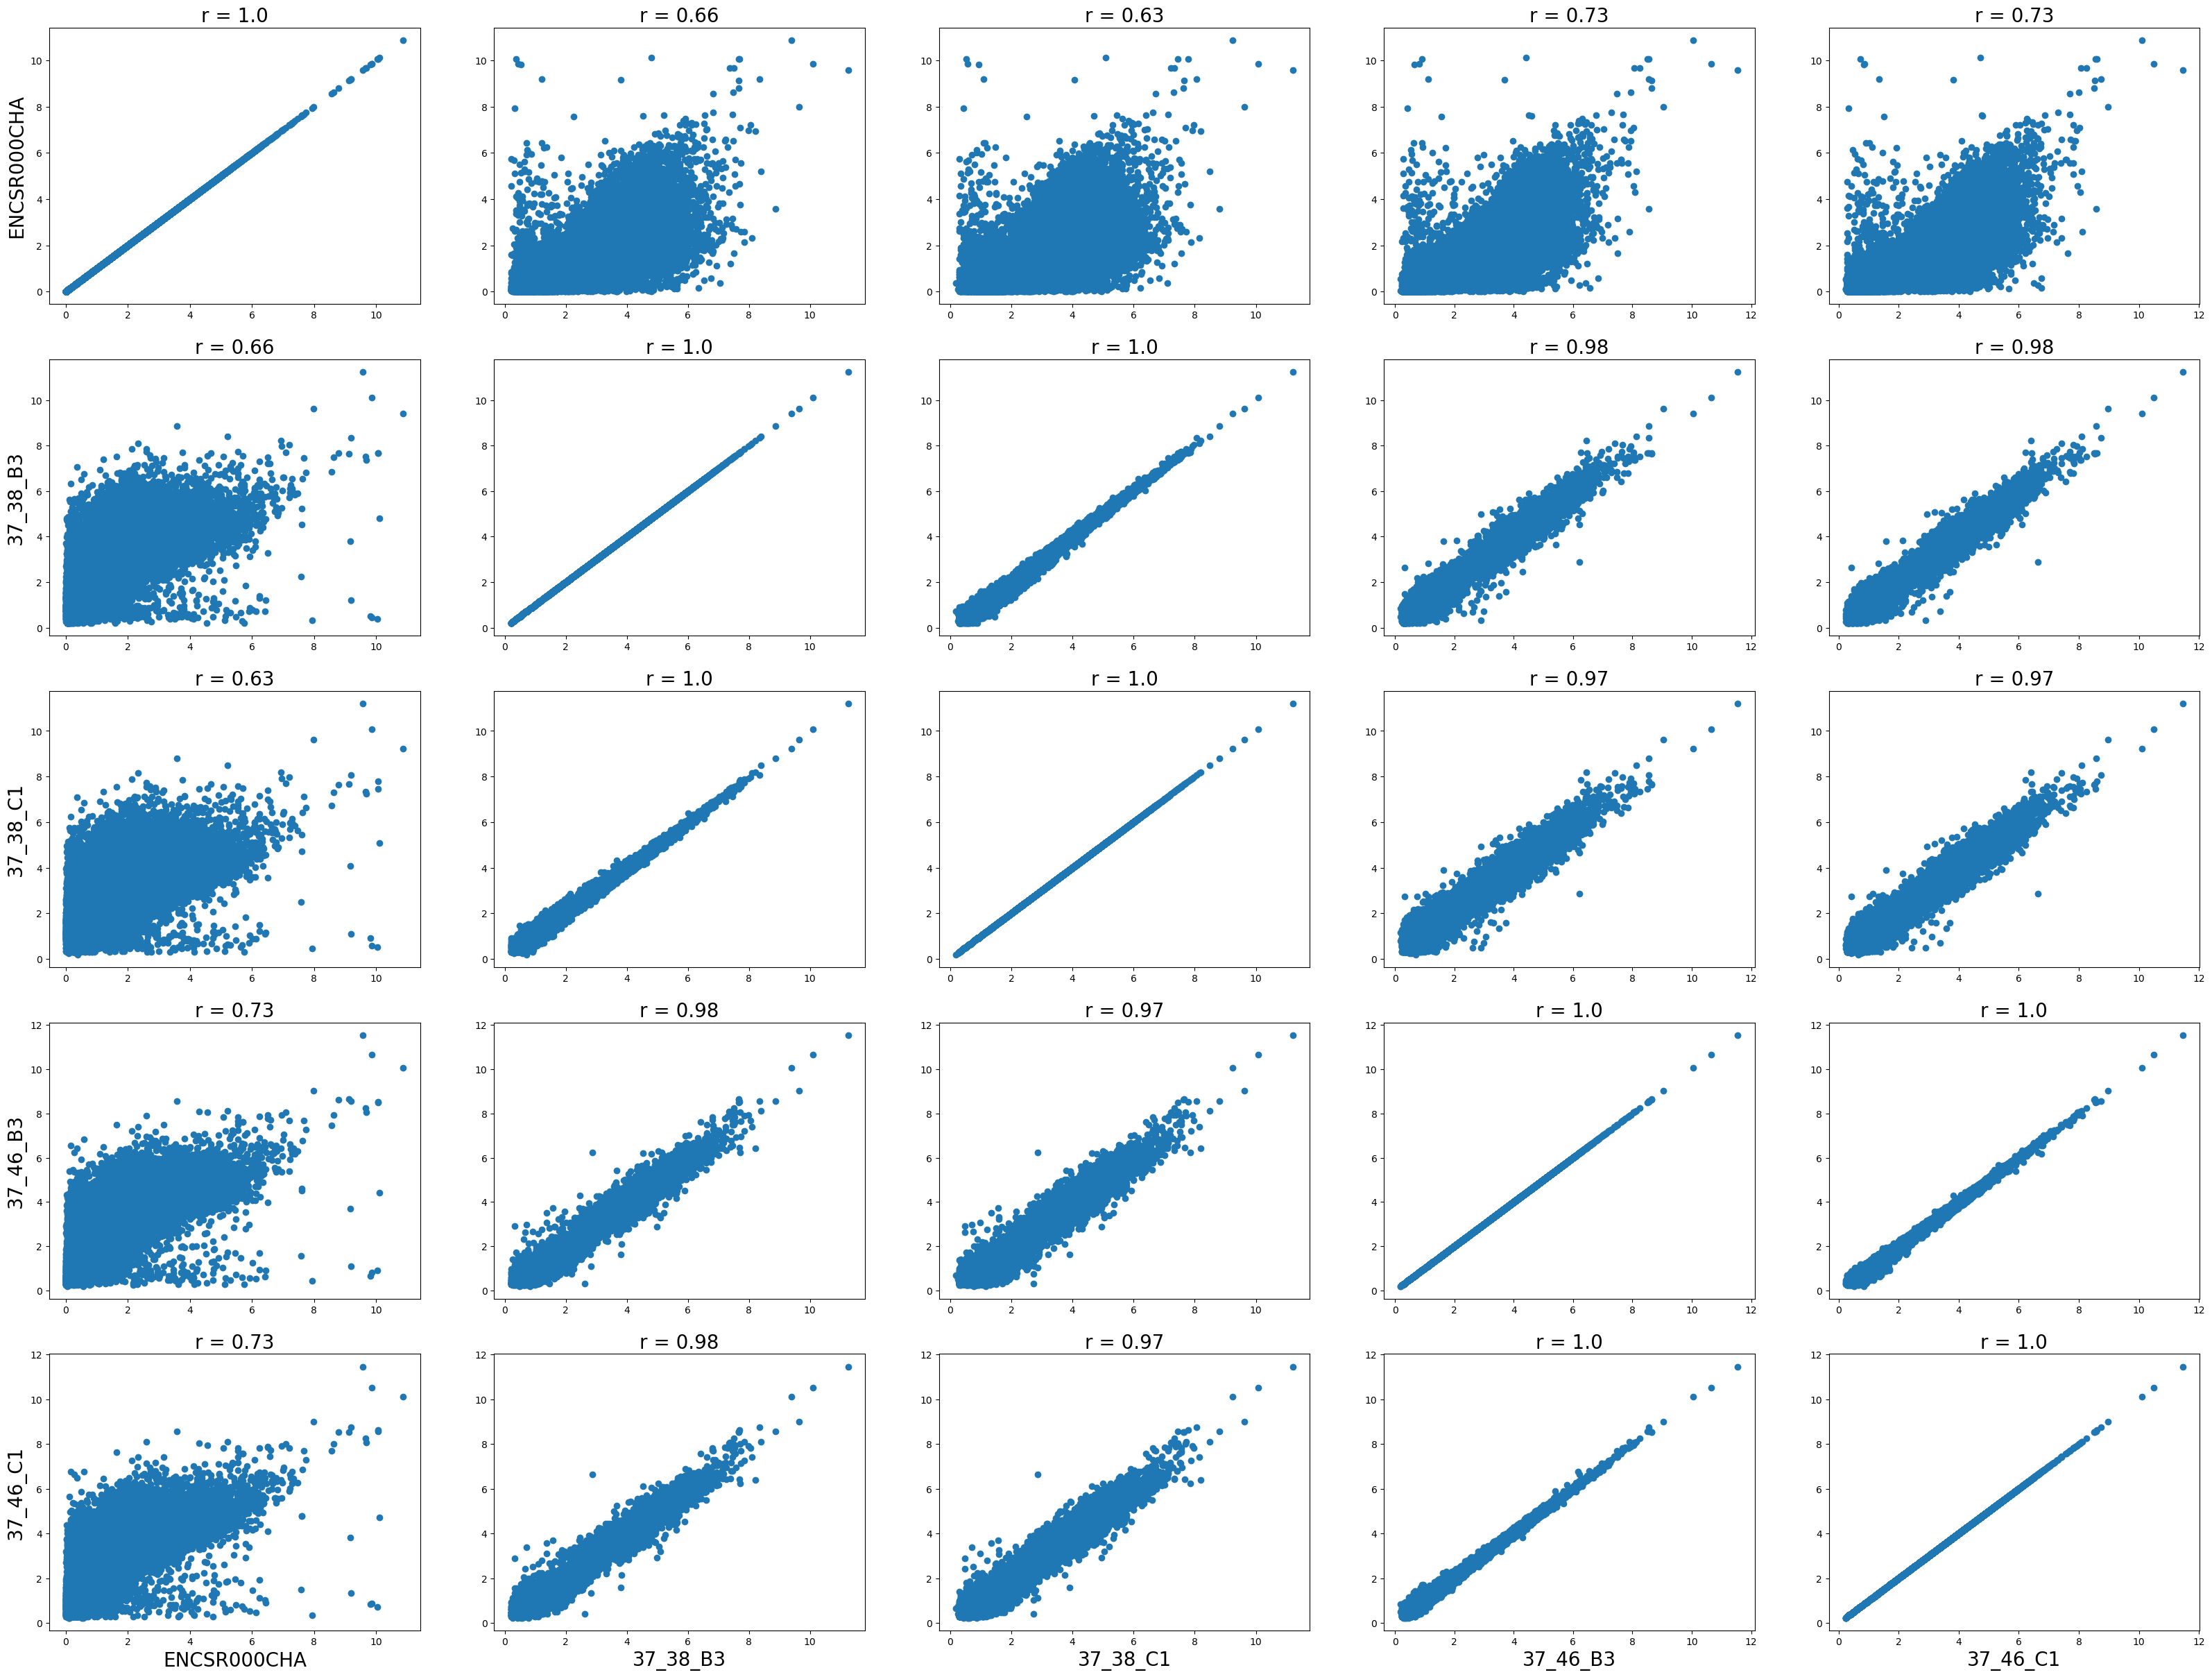

Saving figure to file figures/scatter_pearson_Liver.png
Saved.


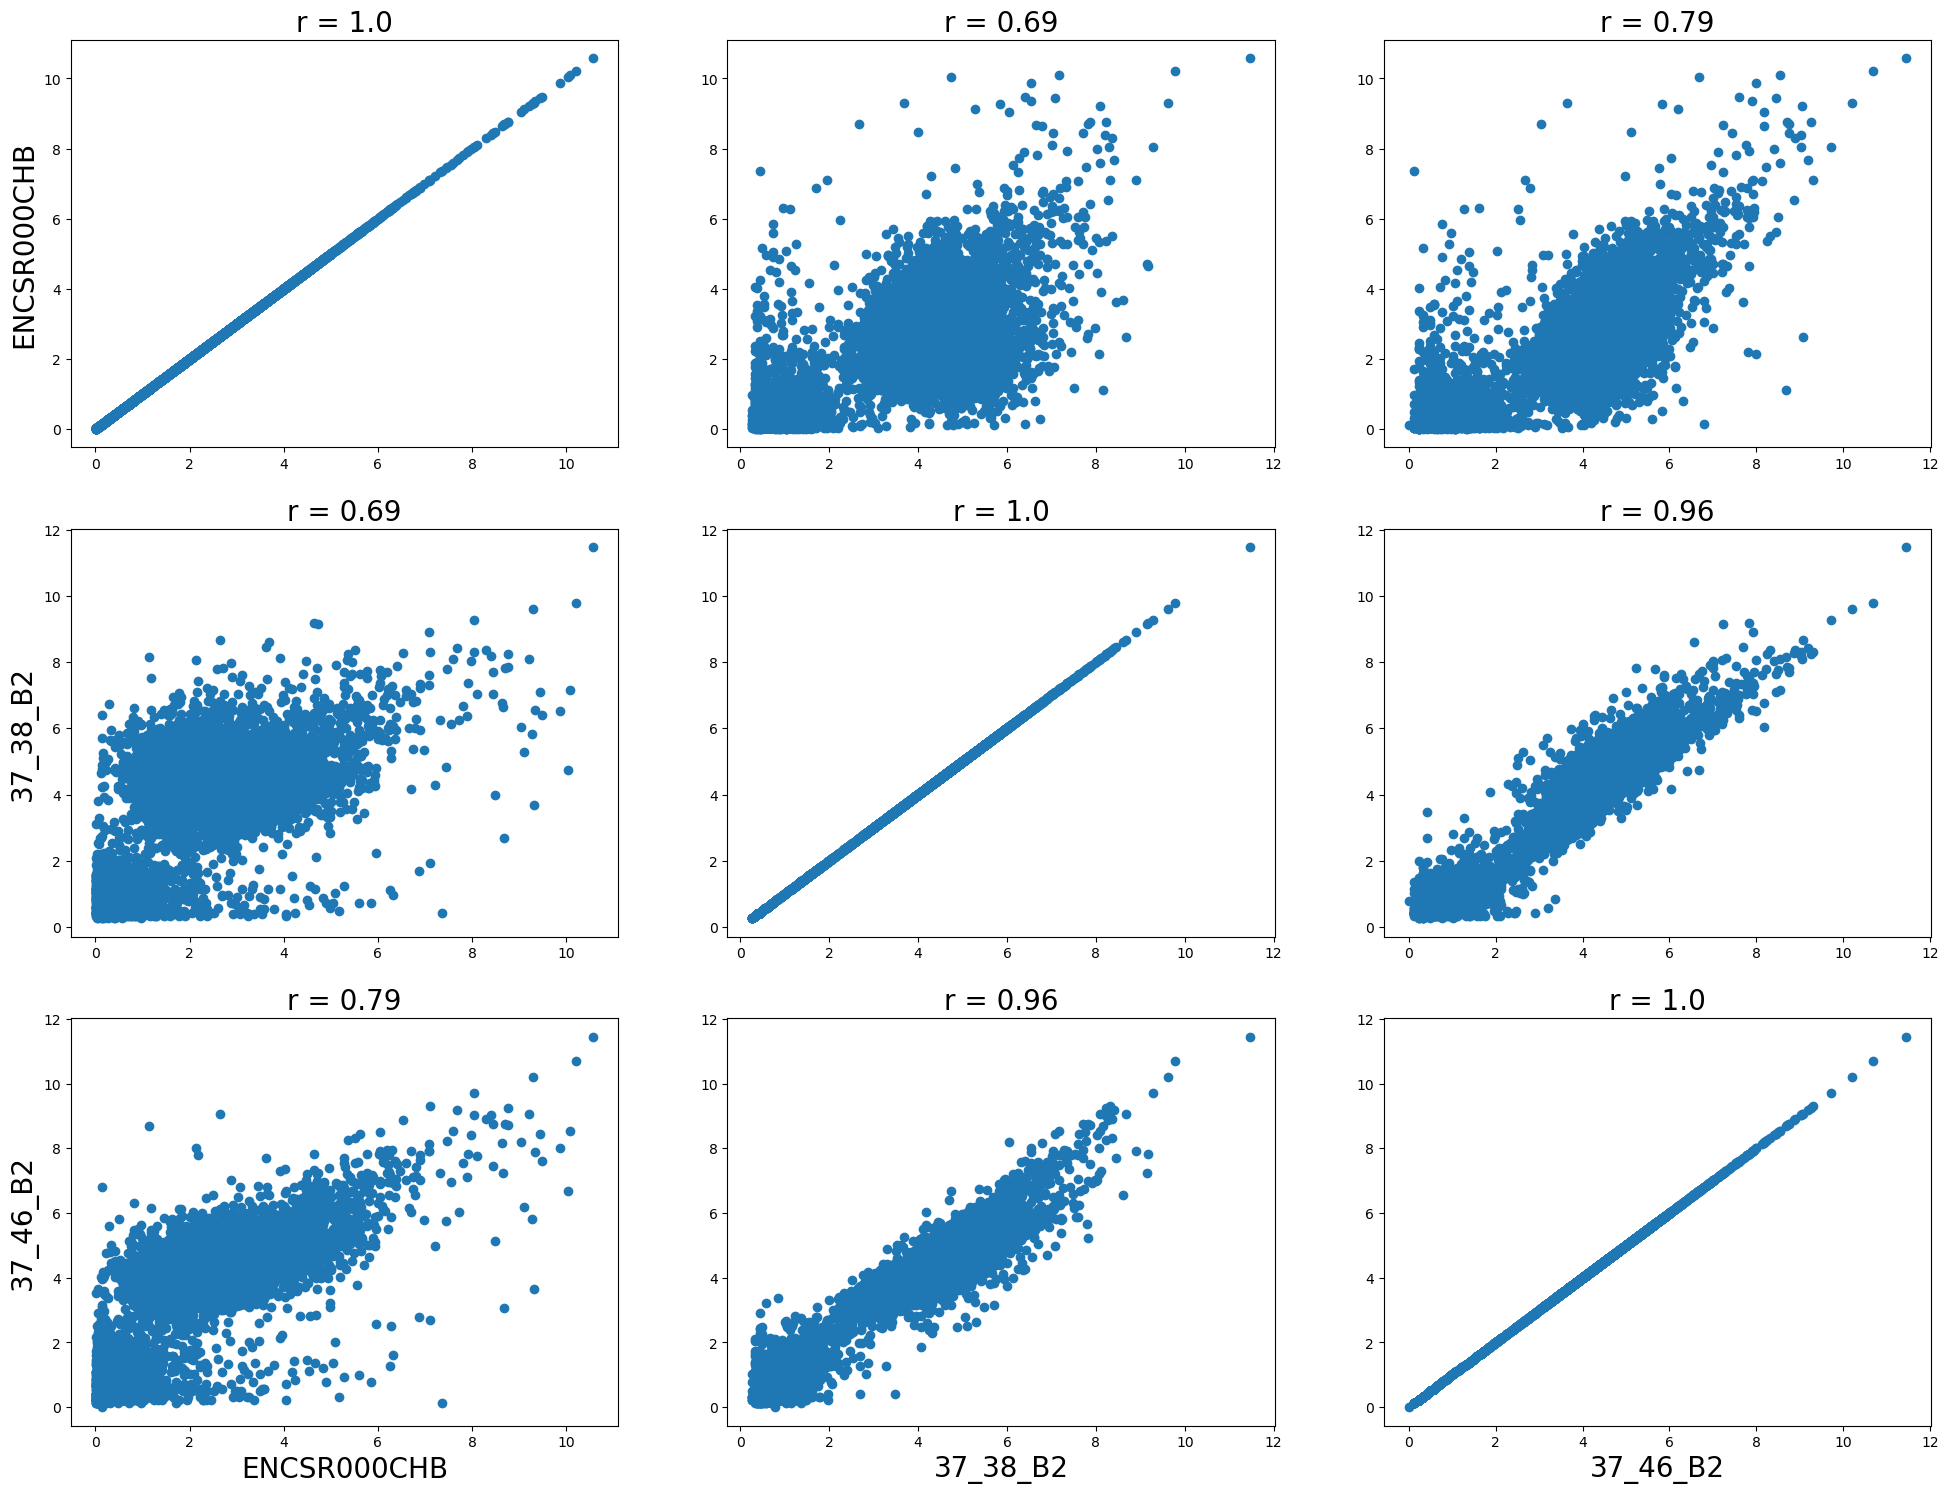

Saving figure to file figures/scatter_pearson_Spleen.png
Saved.


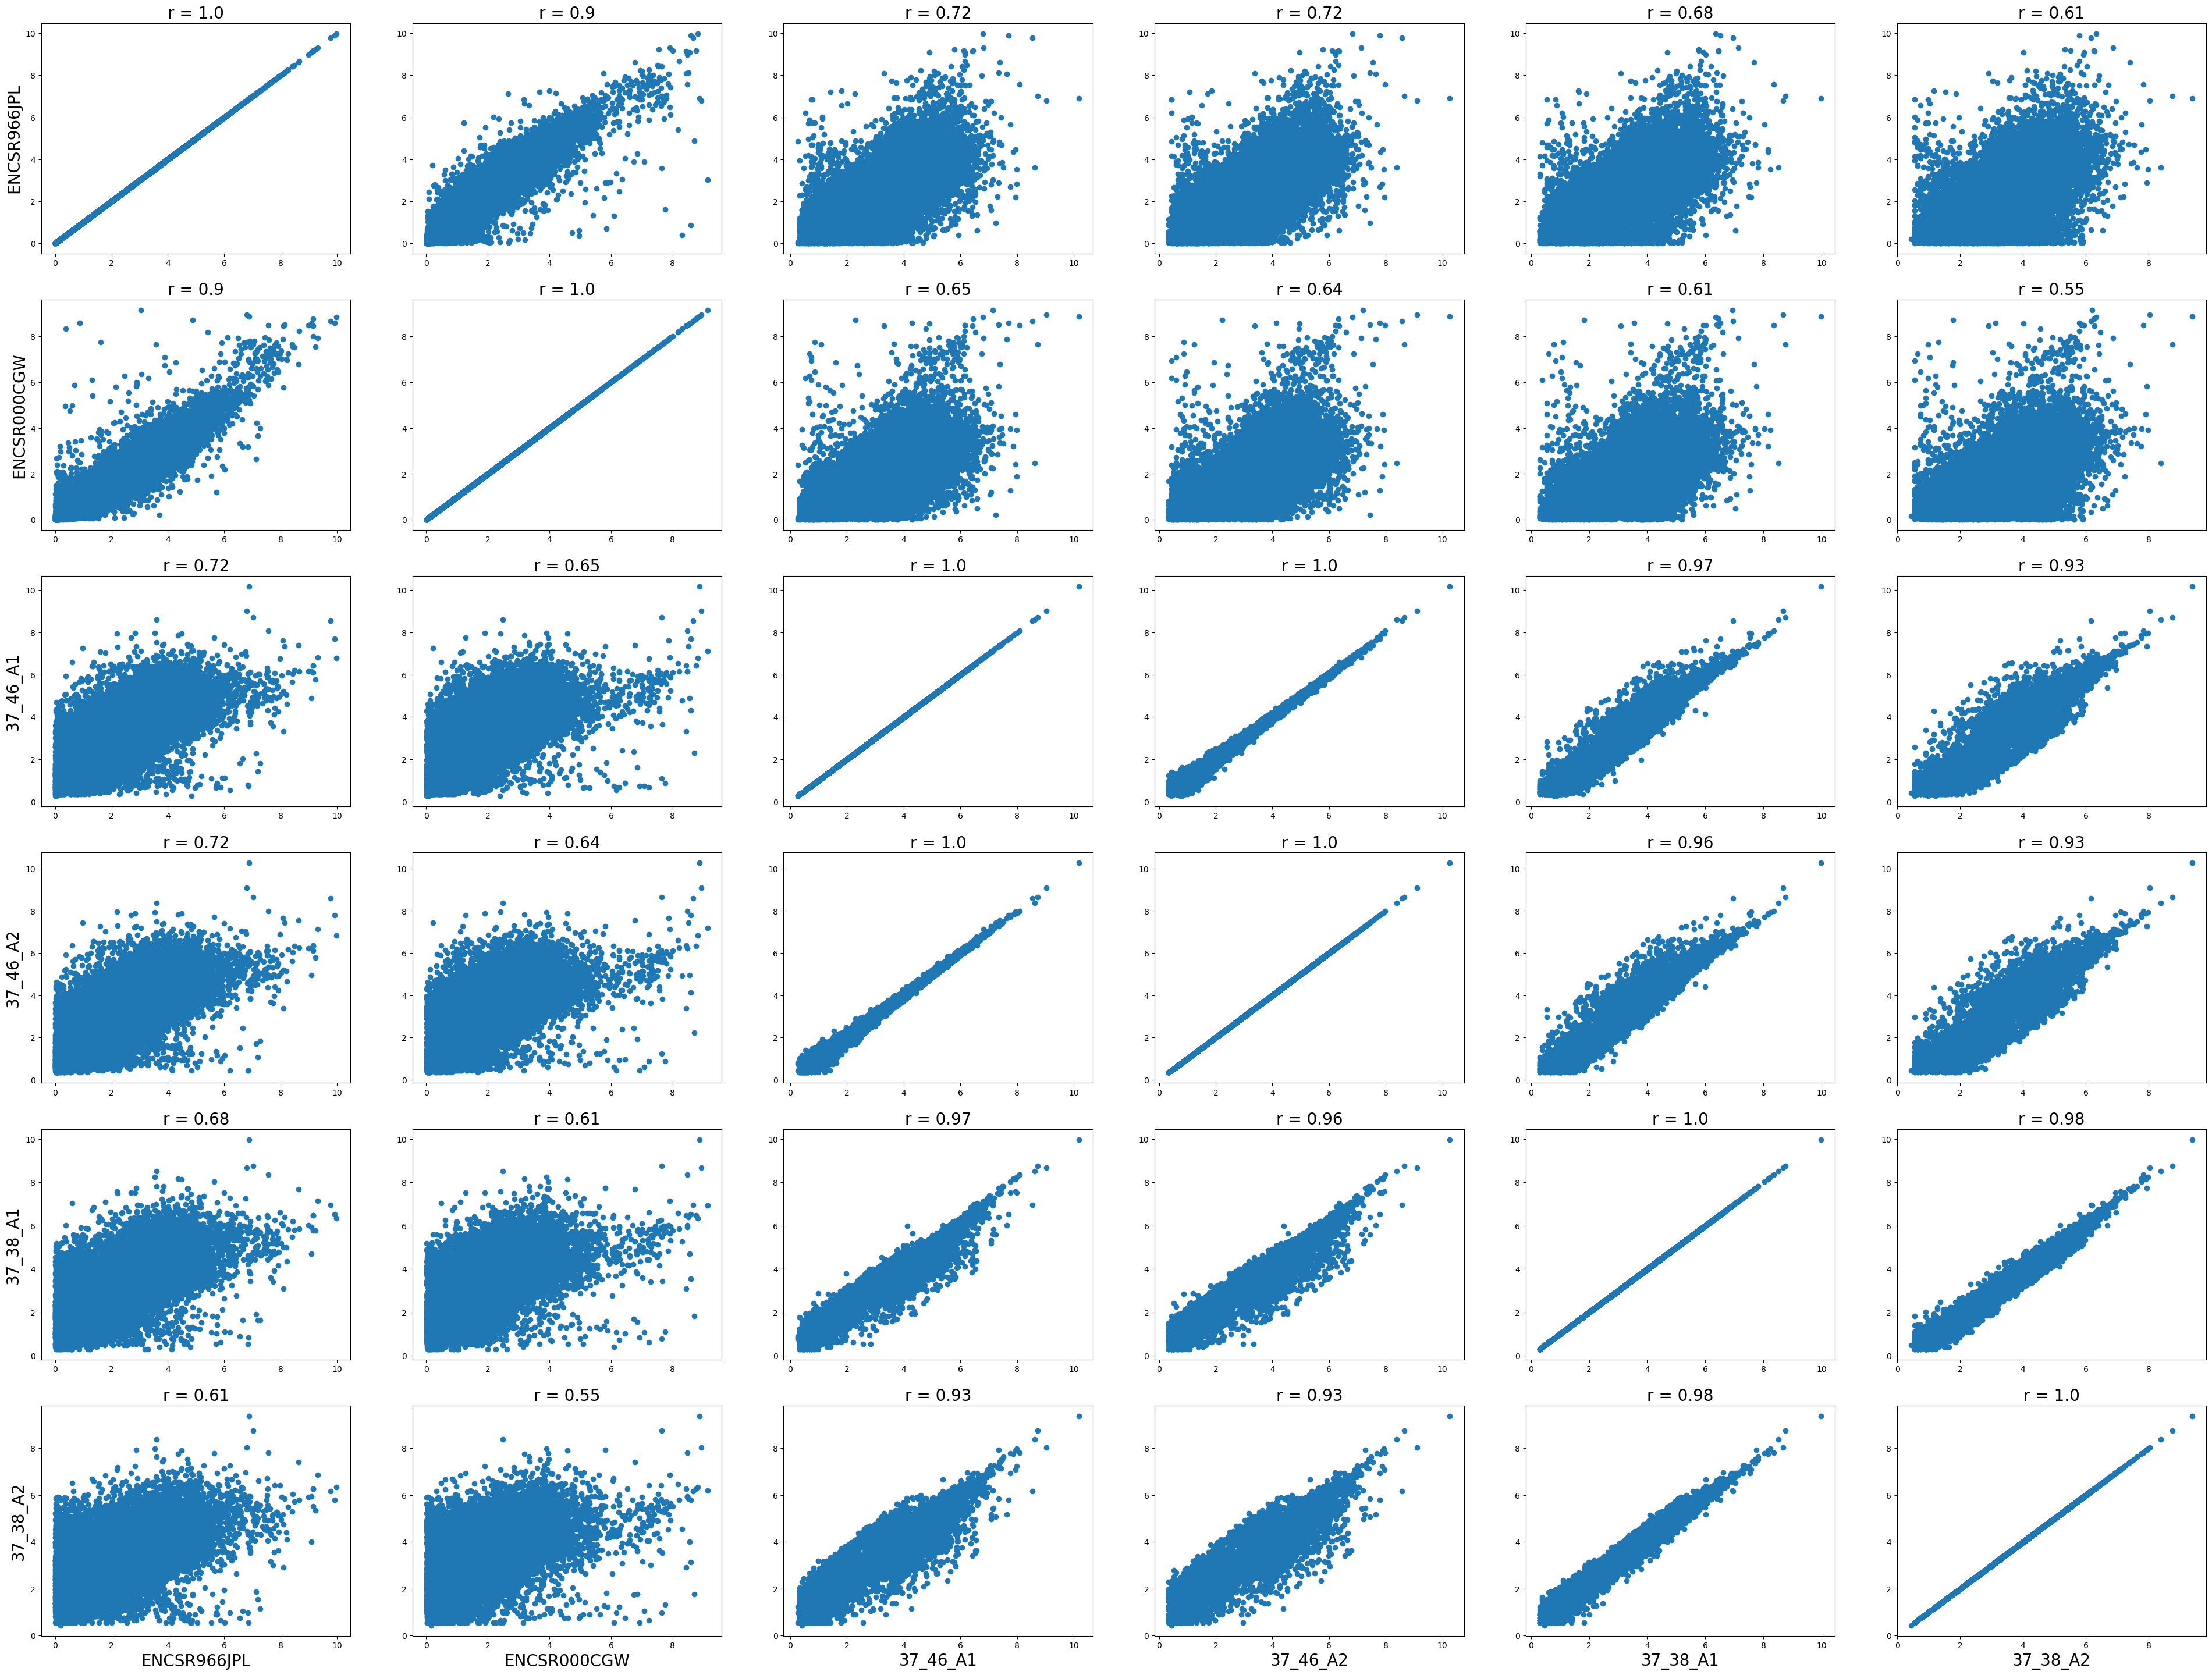

In [22]:
for organ in comb_df.keys():
    pearson_facet_plot(long_df=comb_df[organ], groupby='id', 
                       savepath="figures/scatter_pearson_{}.png".format(organ), dpi_save=300
                      )

### Heatmaps

In [23]:
cormats = {}
for organ, comb in combs.items():
    cormat = comb.to_df().T.corr()
    cormat = cormat.reindex(sorted(cormat.columns), axis=0)
    cormat = cormat.reindex(sorted(cormat.columns), axis=1)
    cormats[organ] = cormat

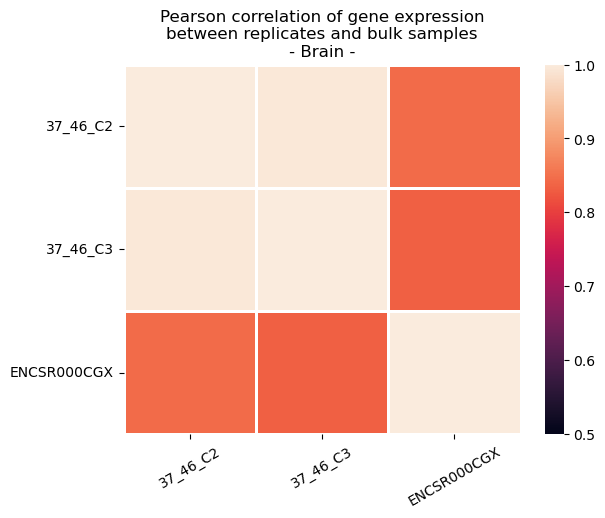

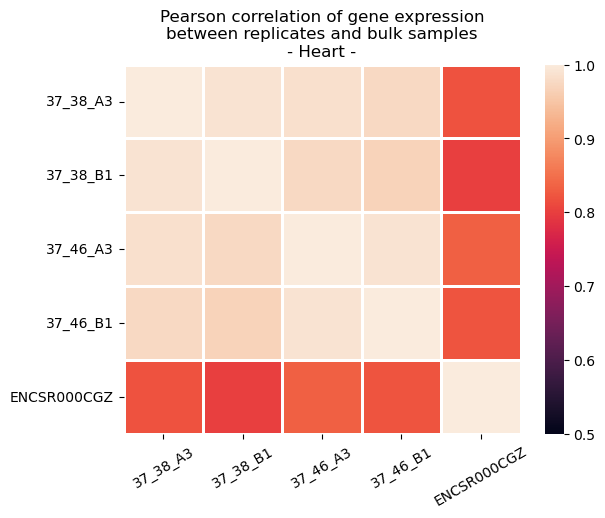

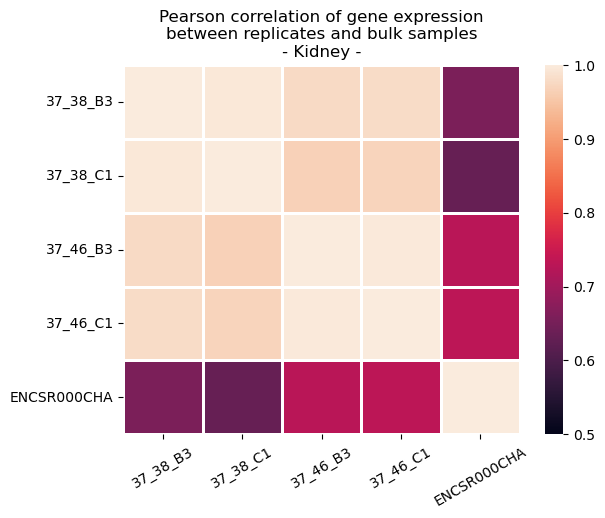

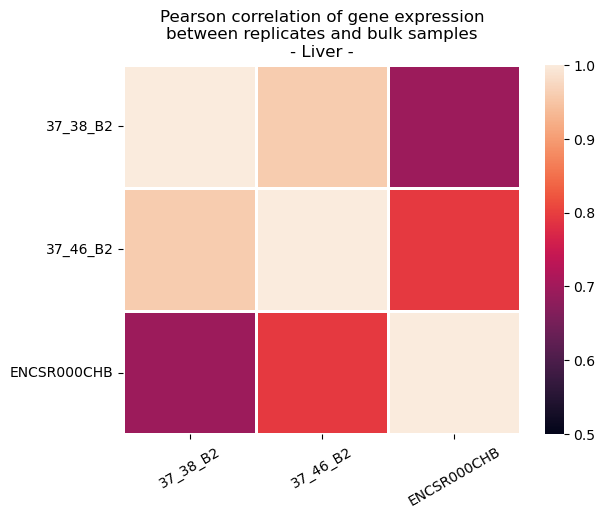

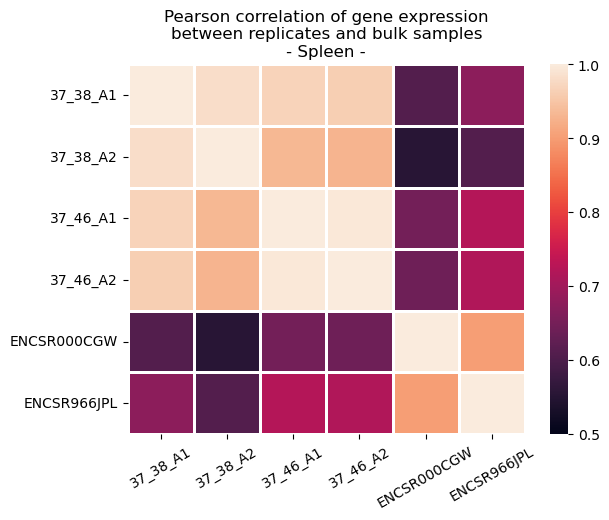

In [24]:
for organ, cormat in cormats.items():
    sns.heatmap(cormat, annot=False, vmin=0.5, vmax=1, linewidths=1, linecolor='w')
    plt.yticks(va='center', rotation=0)
    plt.xticks(ha='center', rotation=30)
    plt.title('Pearson correlation of gene expression\nbetween replicates and bulk samples\n- {} -'.format(organ))
    plt.savefig("figures/heatmap_pearson_bulk_{}.pdf".format(organ), dpi=300, bbox_inches = 'tight')
    plt.show()